In [2]:
import pandas as pd
import os
from glob import glob
import re

folder_path = "../전처리_과정_데이터/원본데이터"
file_paths = glob(os.path.join(folder_path, "*.csv"))

hour_candidates = [str(i) for i in range(1, 25)] + [f"{i:02}시" for i in range(1, 25)]
merged_data = []

def clean_plant_name(filename: str) -> str:
    name_part = filename.replace('.csv', '')  # 확장자 제거
    parts = name_part.split("_")
    if len(parts) >= 2:
        name_candidate = parts[1]
    else:
        name_candidate = parts[0]
    name_candidate = re.sub(r'태양광|발전실적|발전량|[\s_]', '', name_candidate)
    return name_candidate.strip()

for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='cp949')

    file_name = os.path.basename(file_path)
    fallback_plant_name = clean_plant_name(file_name)

    # 날짜 처리
    date_col_candidates = ['년월일', '일자', '날짜']
    date_col = next((col for col in date_col_candidates if col in df.columns), None)
    if date_col is None:
        continue
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # 시간 컬럼 추출
    hour_cols = [col for col in df.columns if col in hour_candidates]
    if not hour_cols:
        continue

    # 발전구분 / 호기 처리
    if '발전기명' in df.columns:
        df['발전구분'] = df['발전기명'].astype(str)
        df['호기'] = '1'
    else:
        df['발전구분'] = fallback_plant_name
        if '호기' in df.columns:
            df['호기'] = df['호기'].astype(str)
        else:
            df['호기'] = '1'

    # melt
    df_melted = df.melt(id_vars=[date_col, '호기', '발전구분'], value_vars=hour_cols,
                        var_name='hour', value_name='발전량')
    df_melted['hour'] = df_melted['hour'].str.extract(r'(\d+)').astype(int)
    df_melted['year'] = df_melted[date_col].dt.year
    df_melted['month'] = df_melted[date_col].dt.month
    df_melted['day'] = df_melted[date_col].dt.day

    df_final = df_melted[['발전구분', '호기', 'year', 'month', 'day', 'hour', '발전량']]
    merged_data.append(df_final)

# 병합
result_df = pd.concat(merged_data, ignore_index=True)

# 호기: 문자열화 + 앞뒤 공백 제거
result_df['호기'] = result_df['호기'].astype(str).str.strip()

# 숫자(정수 or 소수) → 정수 문자열로 변환
result_df['호기'] = result_df['호기'].apply(
    lambda x: str(int(float(x))) if re.fullmatch(r'\d+\.0*', x) else x
)
result_df = result_df[~((result_df['발전구분'] == "(군산)영암F1태양광") & (result_df['호기'] == "1"))]

# 1. 결측치 제거
result_df['발전구분'] = result_df['발전구분'].astype(str).str.strip().replace(['', 'nan', 'NaN'], pd.NA)
result_df['호기'] = result_df['호기'].astype(str).str.strip().replace(['', 'nan', 'NaN'], pd.NA)
result_df = result_df.dropna(subset=['발전구분', '호기'])

# 2. 발전구분에서 '풍력' 포함된 행 제거
result_df = result_df[~result_df['발전구분'].str.contains("풍력", na=False)]

# 4. .csv, .xlsx, .xls 등 확장자 제거
result_df['발전구분'] = result_df['발전구분'].str.replace(r'\.(csv|xlsx?|CSV|XLSX?)$', '', regex=True)

# 발전구분 컬럼의 공백 제거 (띄어쓰기 모두 제거)
result_df['발전구분'] = result_df['발전구분'].str.replace(' ', '', regex=False)

# 발전구분-호기 매핑 확인
mapping_check = result_df[['발전구분', '호기']].drop_duplicates().sort_values(['발전구분', '호기'])

# 결과 출력
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None)
print("✅ 발전구분 수:", result_df['발전구분'].nunique())
print("✅ 발전구분-호기 조합 수:", len(mapping_check))
print("\n📋 발전구분-호기 조합:")
print(mapping_check)

print("\n✅ 데이터 예시:")
print(result_df.head())


✅ 발전구분 수: 43
✅ 발전구분-호기 조합 수: 52

📋 발전구분-호기 조합:
                    발전구분 호기
3045053       (군산)삼랑진태양광  1
2834640       광양항광양냉장태양광  1
2857272        광양항어울림태양광  1
0                  남제주소내  1
2825856         농촌공진도태양광  1
2965896        당진자재창고태양광  1
2858183            당진태양광  1
2967535        당진화력수상태양광  1
2852904  동해바이오연료저장고지붕태양광  1
106608               무릉리  1
140208          부산복합자재창고  1
246816              부산본부  1
249008              부산본부  2
407496            부산수처리장  1
470280              부산신항  1
683496             부산운동장  1
746280              삼척소내  1
746409              삼척소내  2
746762              삼척소내  3
747582              삼척소내  4
3097224     세종시폐기물매립장태양광  1
973176               송당리  1
2859089       수원환경사업소태양광  1
1019136          신인천북측부지  1
1101696            신인천소내  1
1208256           신인천전망대  1
1056264           신인천주차장  1
1271040        신인천해수구취수구  1
1325136              신풍리  1
3097225       안산연성정수장태양광  1
3097226        영암에프원태양광b  1
1358736             영월본부  1
1465320           영월철도부지  1
1

In [2]:
original_dict = {
    "감우리": {"1": 554},
    "남제주소내": {"1": 196},
    "무릉리": {"1": 809},
    "부산복합자재창고": {"1": 187},
    "부산본부": {"1": 392, "2": 502},
    "부산수처리장": {"1": 111},
    "부산신항": {"1": 115},
    "부산운동장": {"1": 1400},
    "삼척소내": {"1": 999, "2": 990, "3": 2002, "4": 2599},
    "송당리": {"1": 997},
    "신인천 북측부지": {"1": 365},
    "신인천소내": {"1": 200},
    "신인천전망대": {"1": 1742},
    "신인천해수구취수구": {"1": 907},
    "신인천 주차장": {"1": 603},
    "신풍리": {"1": 991},
    "영월본부": {"1": 40},
    "영월철도부지": {"1": 1191},
    "용수리": {"1": 889},
    "위미2리": {"1": 995},
    "이천D(백사면B)": {"1": 1000},
    "이천시 백사면A": {"1": 1834},
    "익산 다송리": {"1": 893},
    "인천수산정수장": {"1": 998},
    "하동공설운동장": {"1": 377},
    "하동변전소": {"1": 48},
    "하동보건소": {"1": 41},
    "하동본부": {"1": 997, "2": 1900, "3": 600, "4": 998, "5": 998, "6": 1000},
    "하동정수장": {"1": 93},
    "하동하수처리장": {"1": 54},
    "화촌주민참여형": {"1": 1000},
    "당진자재창고태양광": {"1": 700},
    "당진태양광": {"1": 1000},
    "당진화력수상태양광": {"1": 1000},
    "울산태양광#1": {"1": 500},
    "광양항광양냉장태양광": {"1": 700},
    "광양항어울림태양광": {"1": 600},
    "수원환경사업소태양광": {"1": 1500},
    "농촌공진도태양광": {"1": 994},
    "동해바이오연료저장고지붕태양광": {"1": 1000},
    "(군산)삼랑진태양광": {"1": 2000},
    "태안#9,10수상태양광": {"1": 1836},
    "세종시폐기물매립장태양광": {"1": 1628},
    "안산연성정수장태양광": {"1": 1490},
    "영암에프원태양광b": {"1": 13296},
}


# 1. original_dict의 값을 조회할 수 있게 flatten
plant_capacity_map = []

for plant, units in original_dict.items():
    for unit, capacity in units.items():
        plant_capacity_map.append({
            '발전구분': plant.replace(" ", ""),  # 공백 제거
            '호기': str(unit),
            '설비용량(kW)': capacity
        })

df_capacity = pd.DataFrame(plant_capacity_map)

# 3. 설비용량 매핑 (left join)
result_df = result_df.merge(df_capacity, on=['발전구분', '호기'], how='left')
# kW → MW
result_df['설비용량(MW)'] = result_df['설비용량(kW)'] / 1000

# 누락된 행 추출
missing_capacity = result_df[result_df['설비용량(kW)'].isna()]

# 출력
if missing_capacity.empty:
    print("✅ 모든 발전구분-호기 조합에 대해 설비용량이 정확히 매핑되었습니다.")
else:
    print("❌ 아래 조합은 original_dict에 설비용량 정보가 없습니다:")
    print(missing_capacity[['발전구분', '호기']].drop_duplicates())

# 발전구분-호기별 설비용량(MW) 확인
capacity_by_unit = (
    result_df[['발전구분', '호기', '설비용량(MW)']]
    .drop_duplicates()
    .sort_values(['발전구분', '호기'])
)

pd.set_option('display.max_rows', None)
print(capacity_by_unit)

# ✅ 설비용량(kW) 컬럼 제거
if '설비용량(kW)' in result_df.columns:
    result_df = result_df.drop(columns=['설비용량(kW)'])


✅ 모든 발전구분-호기 조합에 대해 설비용량이 정확히 매핑되었습니다.
                    발전구분 호기  설비용량(MW)
3014592       (군산)삼랑진태양광  1     2.000
2825856       광양항광양냉장태양광  1     0.700
2848488        광양항어울림태양광  1     0.600
0                  남제주소내  1     0.196
2817096         농촌공진도태양광  1     0.994
2935800        당진자재창고태양광  1     0.700
2849399            당진태양광  1     1.000
2937439        당진화력수상태양광  1     1.000
2844120  동해바이오연료저장고지붕태양광  1     1.000
106608               무릉리  1     0.809
140208          부산복합자재창고  1     0.187
246816              부산본부  1     0.392
249008              부산본부  2     0.502
407496            부산수처리장  1     0.111
470280              부산신항  1     0.115
683496             부산운동장  1     1.400
746280              삼척소내  1     0.999
746409              삼척소내  2     0.990
746762              삼척소내  3     2.002
747582              삼척소내  4     2.599
3040848     세종시폐기물매립장태양광  1     1.628
973176               송당리  1     0.997
2850305       수원환경사업소태양광  1     1.500
1019136          신인천북측부지  1     0.365
1101696    

In [3]:
result_df.head()

,발전구분,호기,year,month,day,hour,발전량,설비용량(MW)
0,남제주소내,1,2013.0,1.0,1.0,1,0.0,0.196
1,남제주소내,1,2013.0,1.0,2.0,1,0.0,0.196
2,남제주소내,1,2013.0,1.0,3.0,1,0.0,0.196
3,남제주소내,1,2013.0,1.0,4.0,1,0.0,0.196
4,남제주소내,1,2013.0,1.0,5.0,1,0.0,0.196


In [4]:
# result_df의 유니크한 발전구분만 추출
df_plant_names = set(result_df['발전구분'].unique())

# original_dict의 키 집합
dict_plant_names = set(original_dict.keys())

# 매핑이 누락된 발전소명 추출
unmapped = df_plant_names - dict_plant_names

print("❌ 매핑되지 않은 발전소명:")
for name in sorted(unmapped):
    print(name)


❌ 매핑되지 않은 발전소명:
신인천북측부지
신인천주차장
이천시백사면A


In [5]:
# ✅ 발전량과 설비용량 문자열 처리 → 숫자(float)로 변환
def safe_to_float(x):
    try:
        return float(str(x).replace(',', '').strip())
    except:
        return np.nan  # 변환 실패시 NaN 처리

import numpy as np

result_df['발전량'] = result_df['발전량'].apply(safe_to_float)
result_df['설비용량(MW)'] = result_df['설비용량(MW)'].apply(safe_to_float)

# ✅ 변환 실패로 NaN 된 행 제거
result_df = result_df.dropna(subset=['발전량', '설비용량(MW)'])


In [6]:
import pandas as pd

# ✅ 발전효율 재계산 (단위: kWh / kW)
result_df['발전효율'] = result_df['발전량'] / (result_df['설비용량(MW)'] * 1000)

# ✅ 발전효율이 1 이상인 발전구분-호기 조합 찾기
mask_invalid = result_df['발전효율'] > 100.0
invalid_combinations = result_df.loc[mask_invalid, ['발전구분', '호기']].drop_duplicates()

# ✅ 조합별로 발전량을 1000으로 나누어 수정
for _, row in invalid_combinations.iterrows():
    plant = row['발전구분']
    unit = row['호기']
    idx = (result_df['발전구분'] == plant) & (result_df['호기'] == unit)
    result_df.loc[idx, '발전량'] = result_df.loc[idx, '발전량'] / 1000

# ✅ 보정 후 발전효율 다시 계산
result_df['발전효율'] = result_df['발전량'] / (result_df['설비용량(MW)'] * 1000)


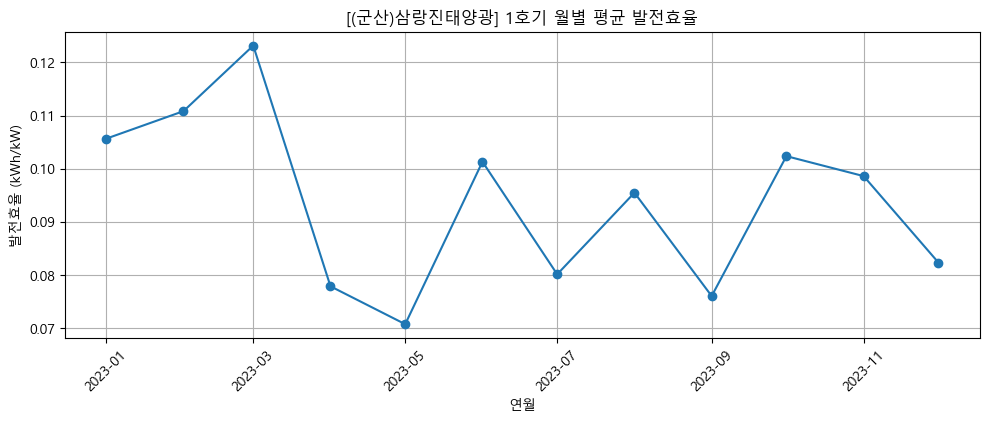

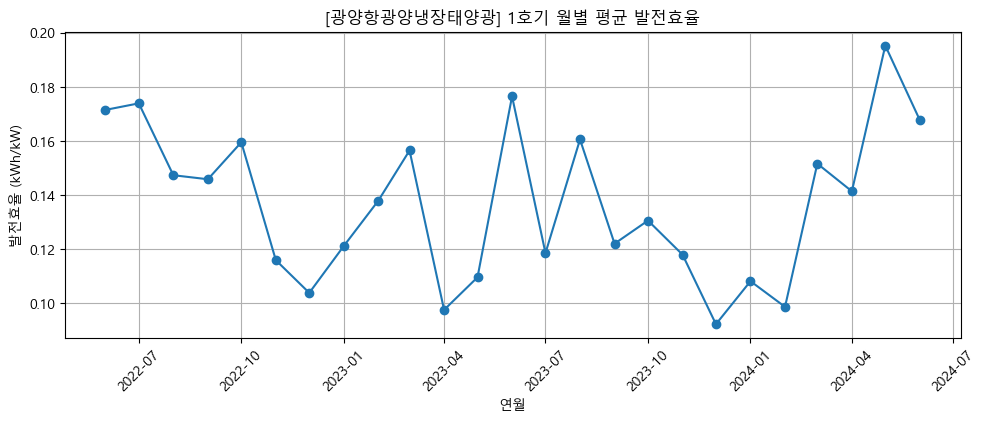

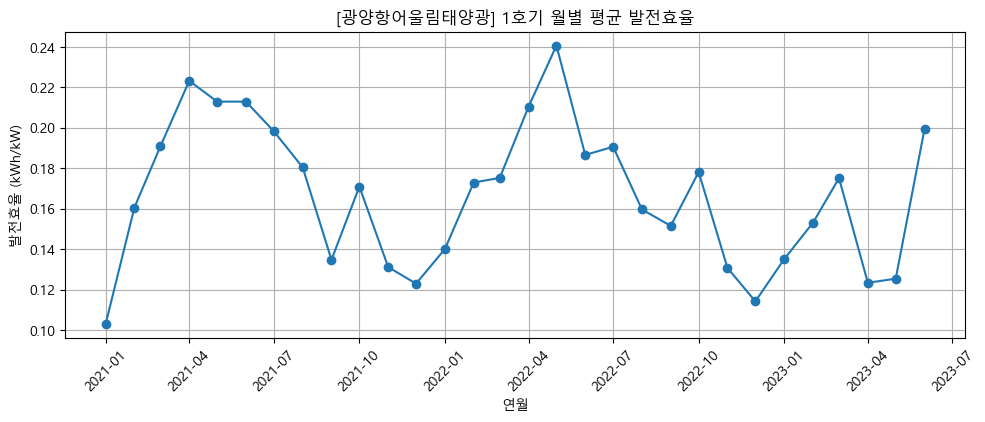

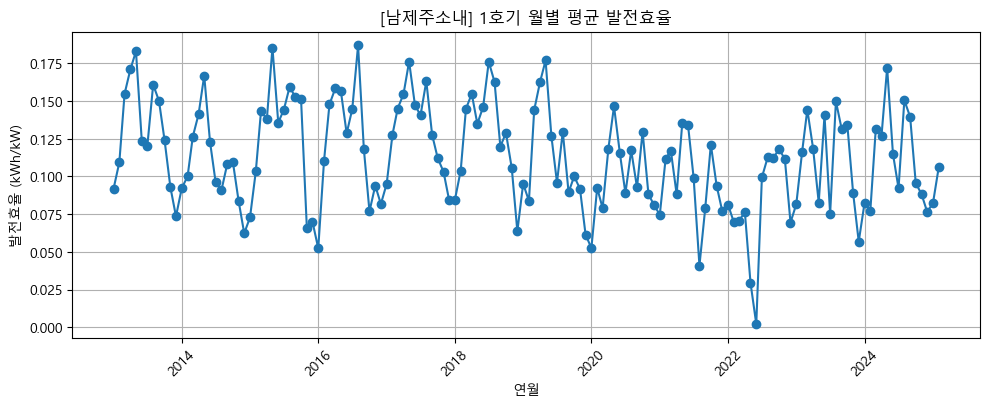

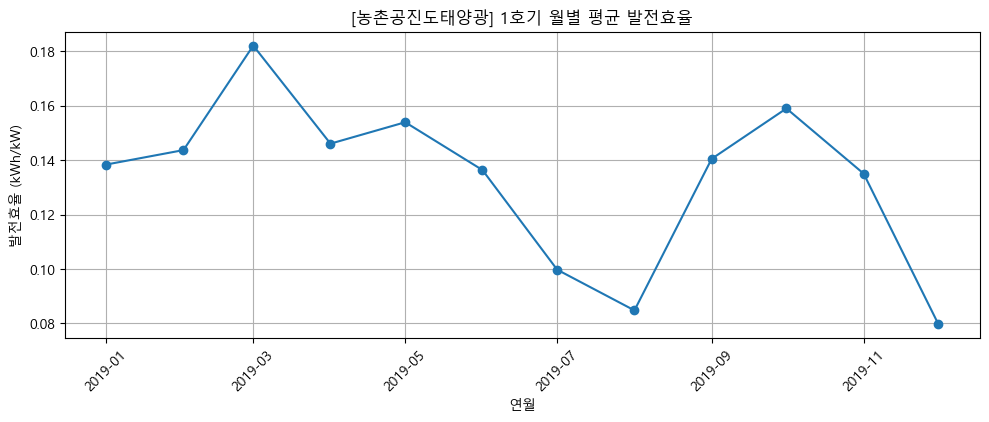

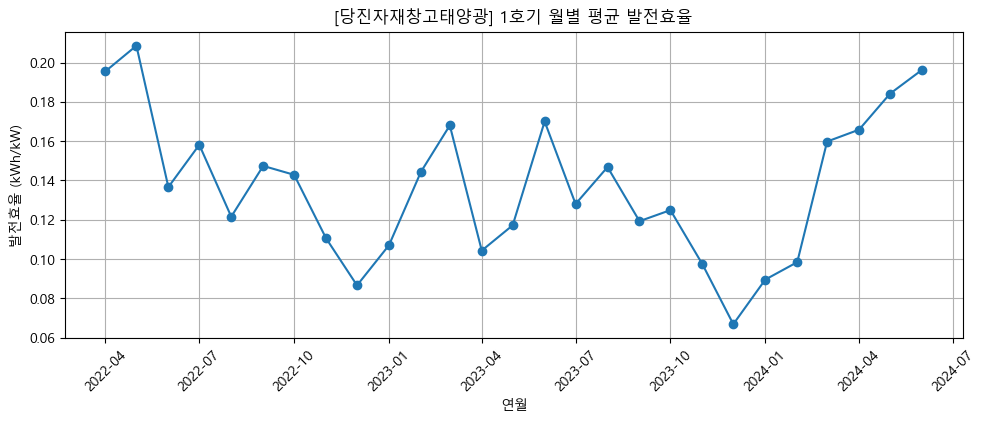

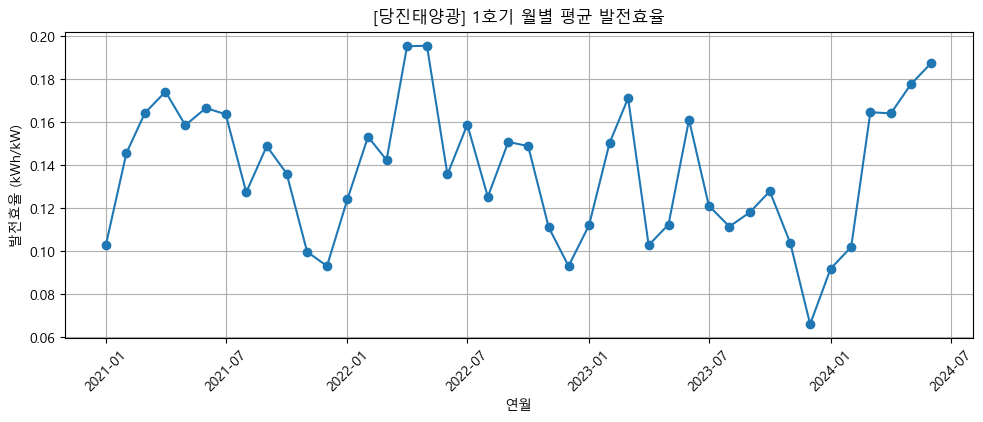

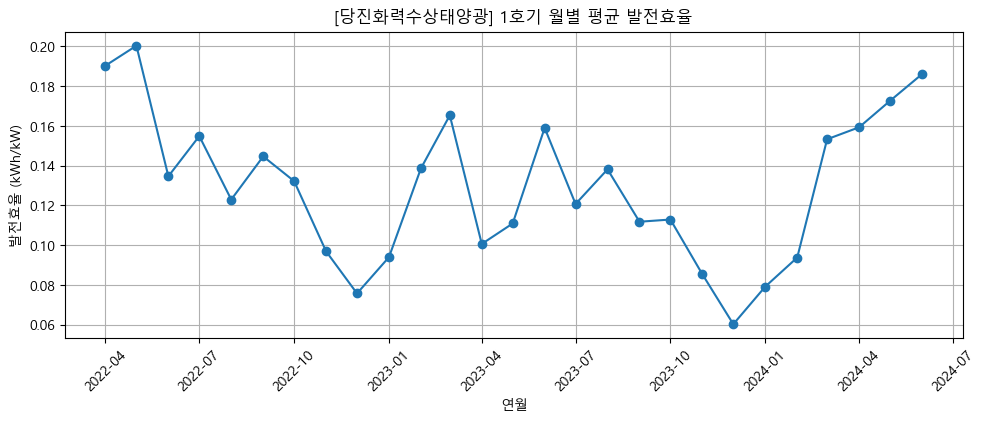

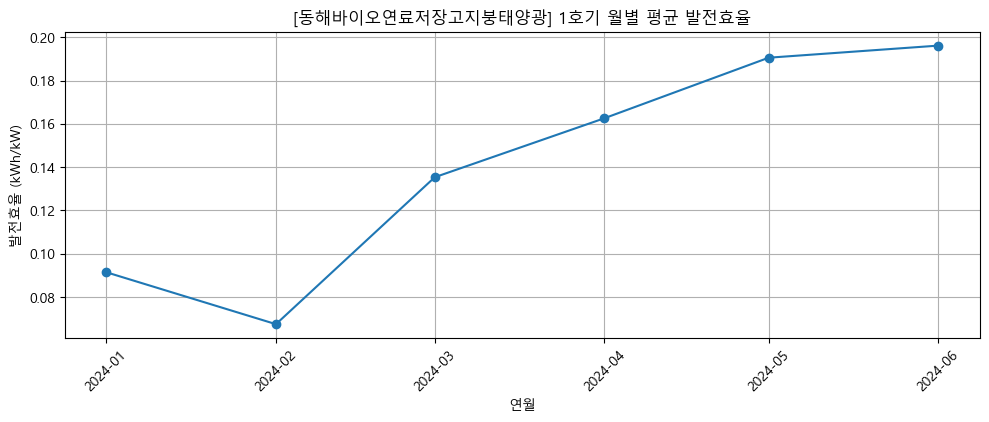

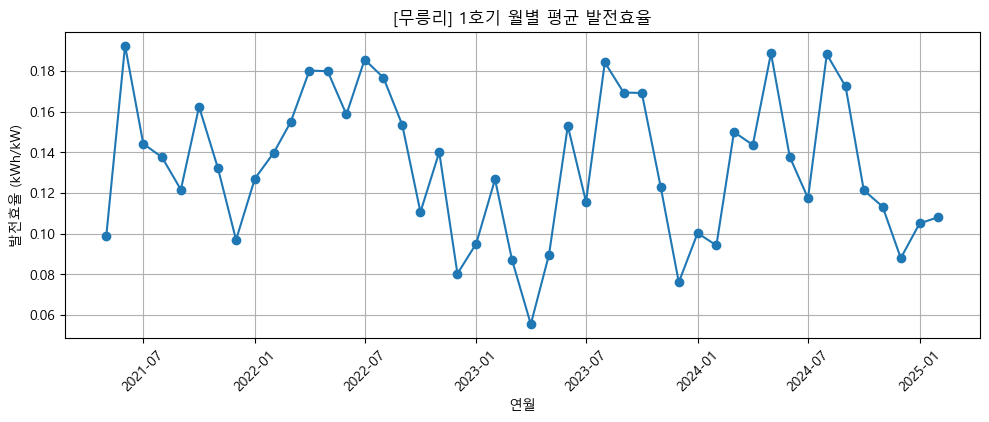

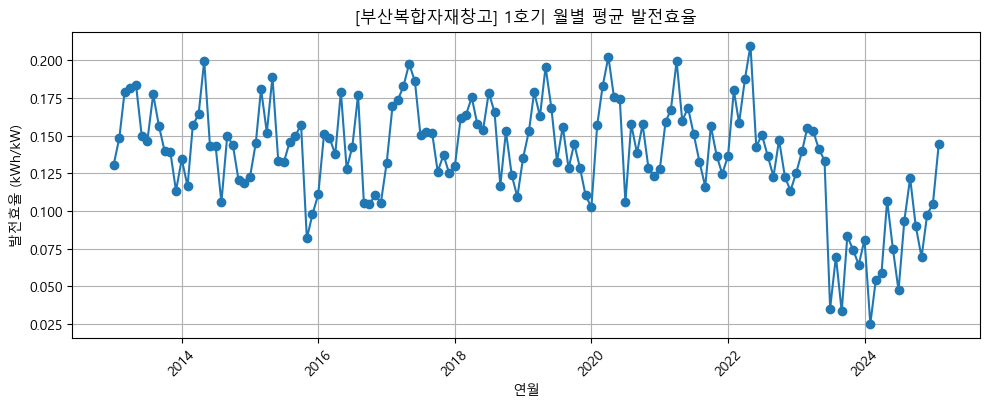

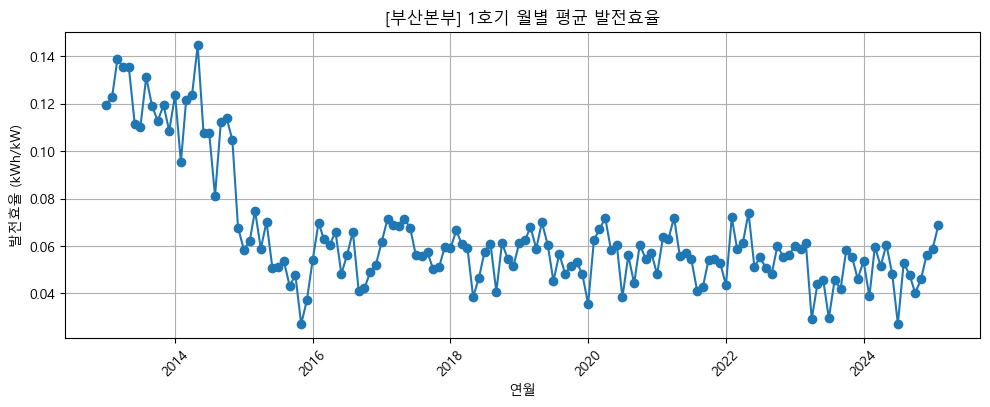

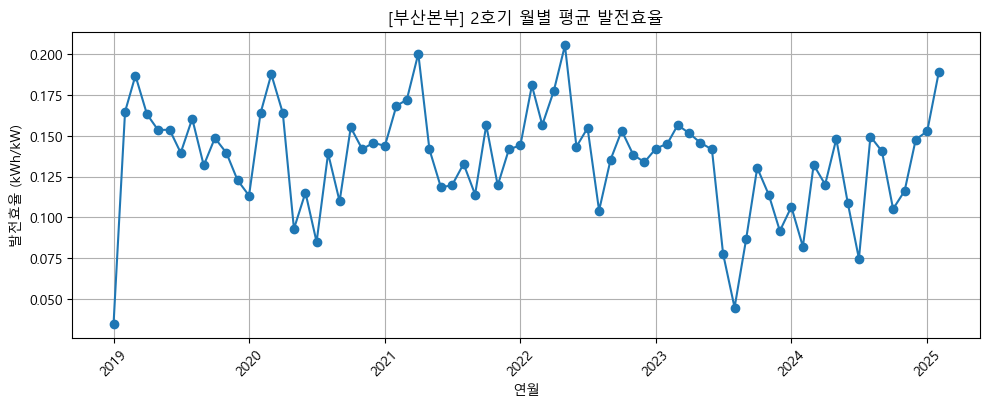

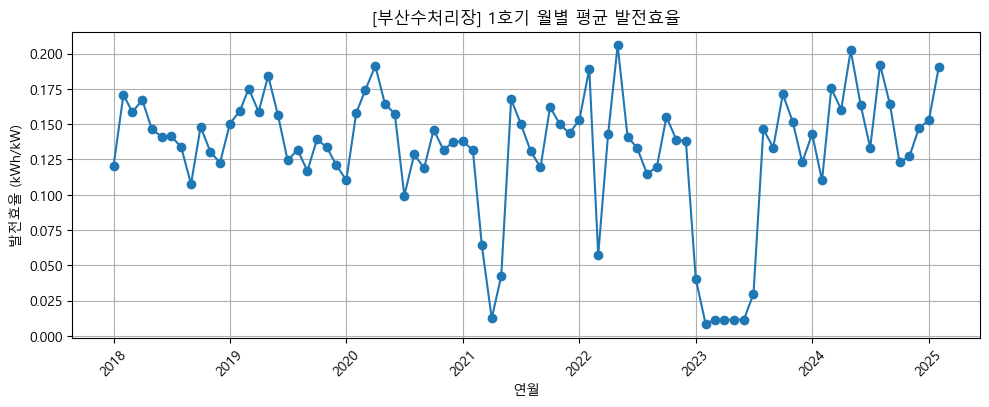

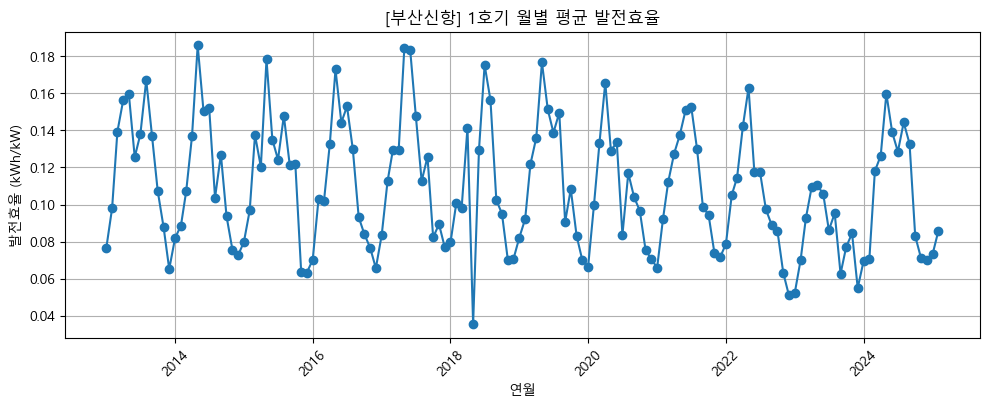

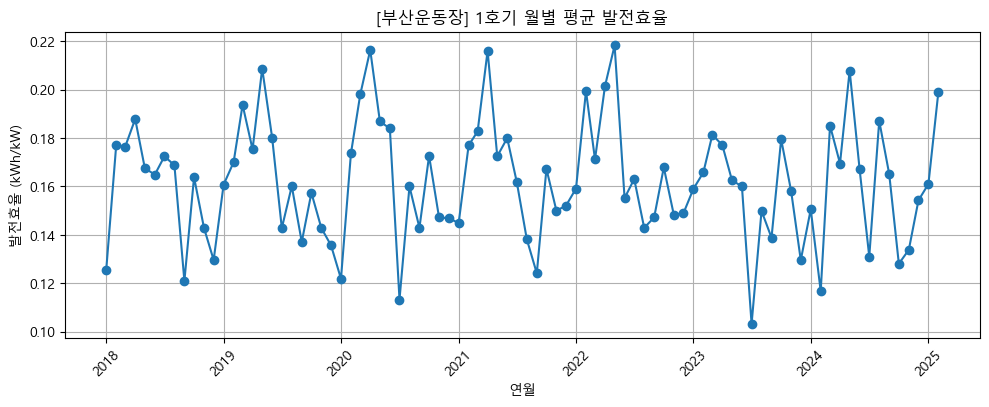

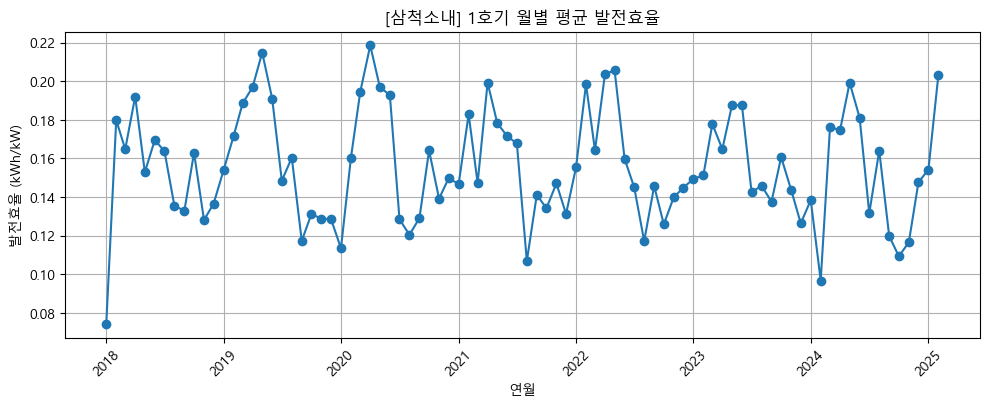

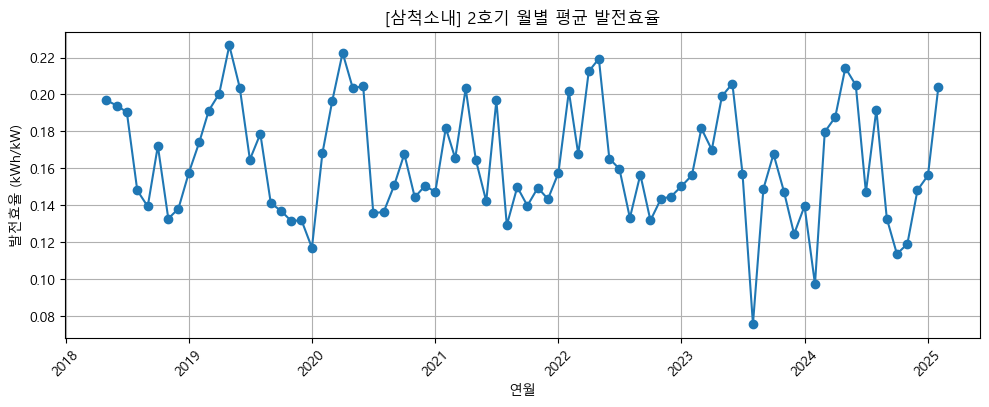

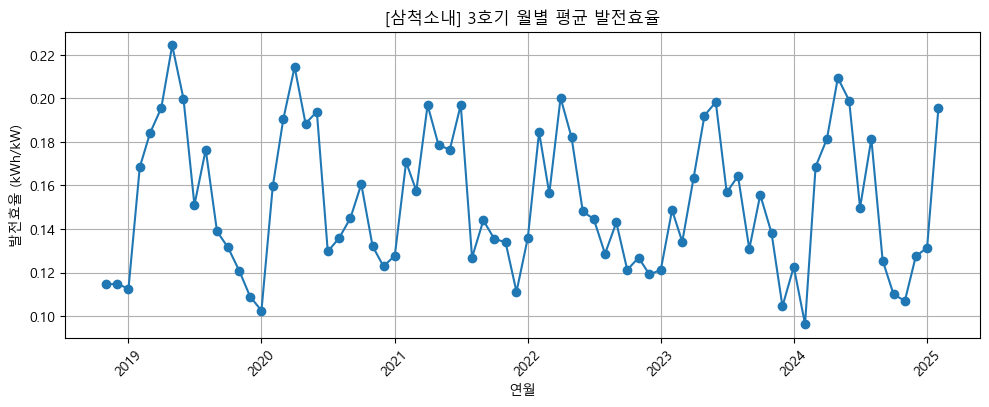

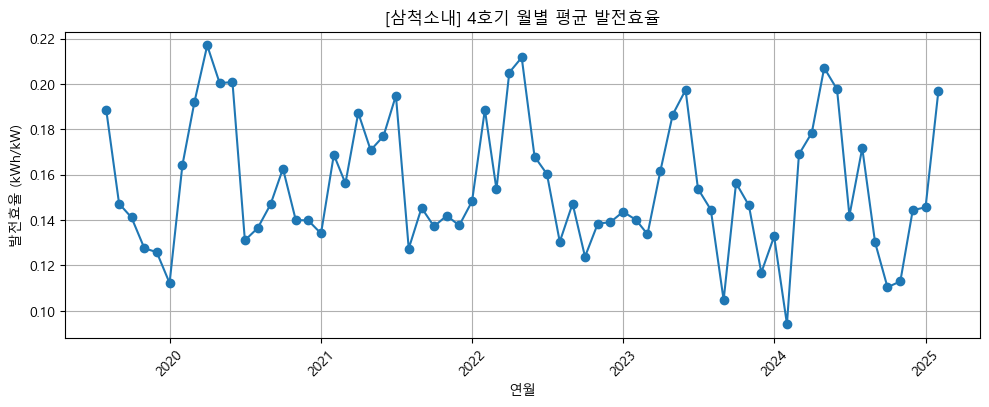

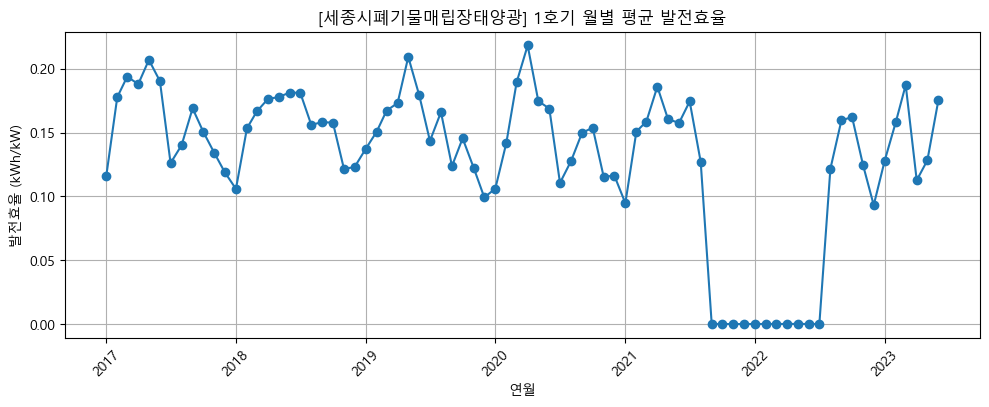

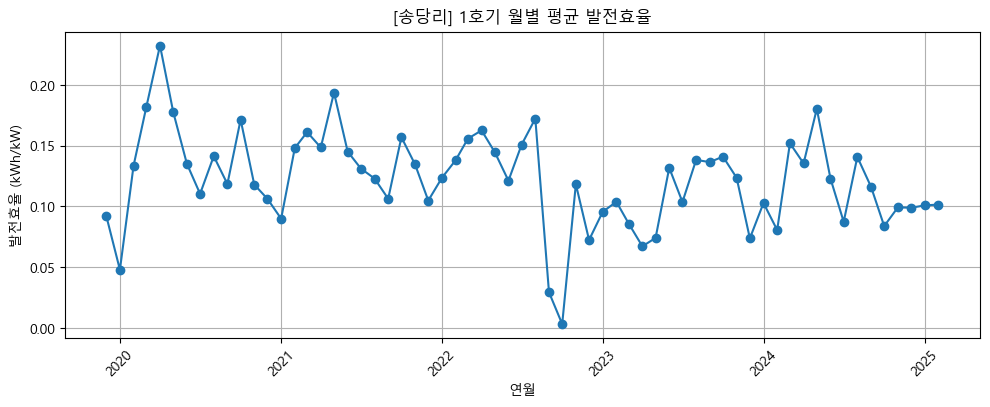

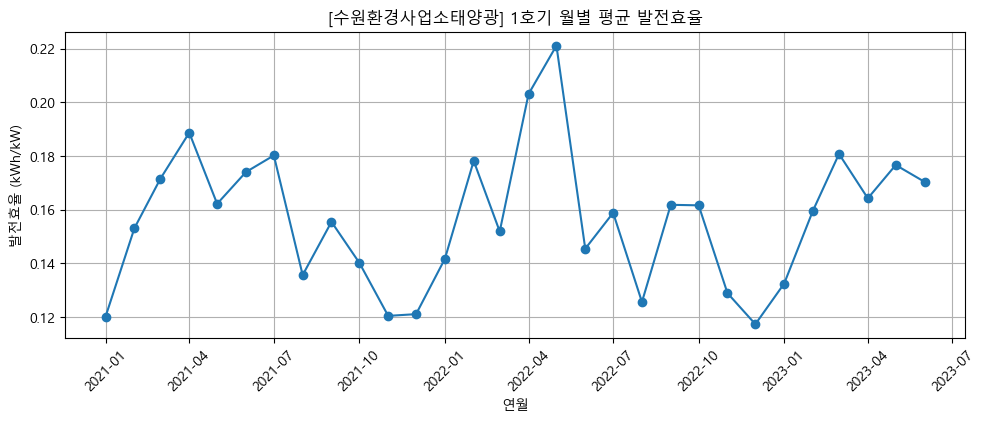

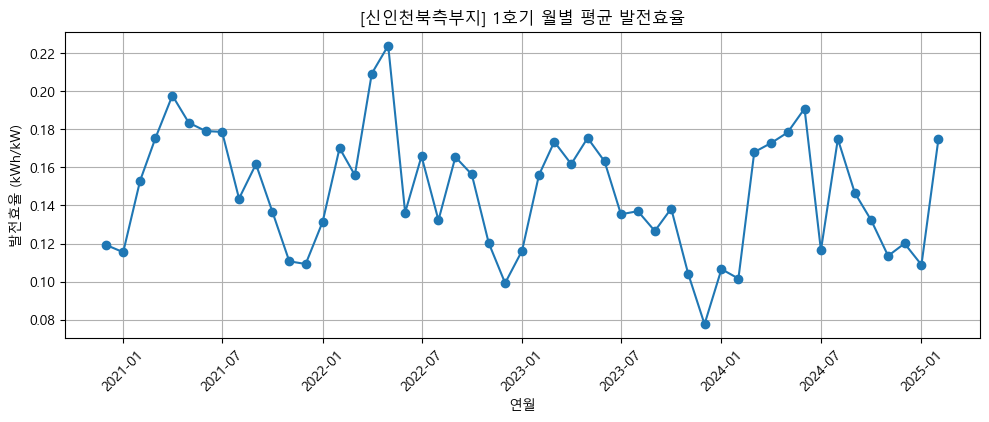

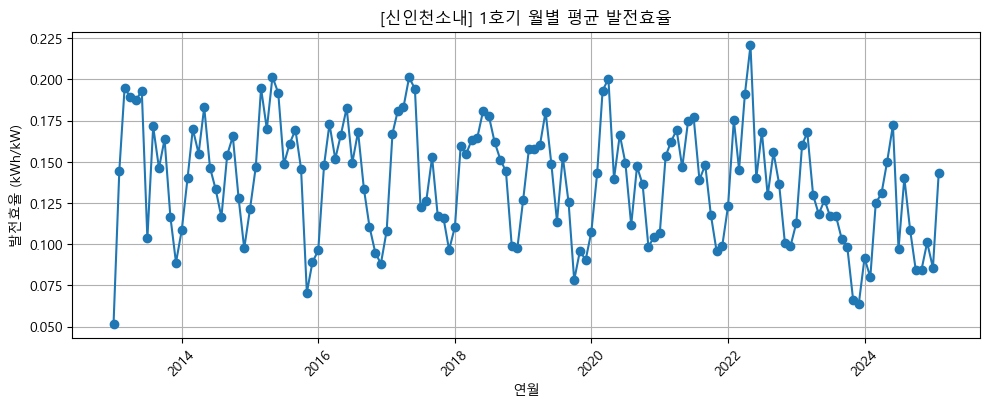

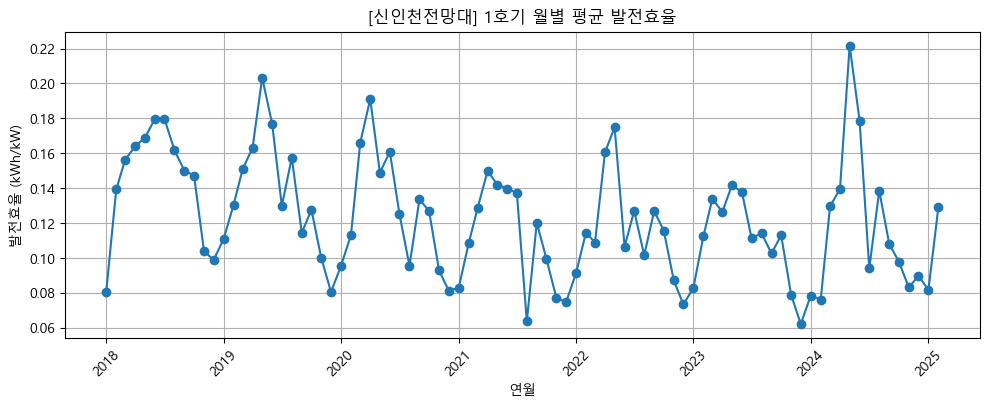

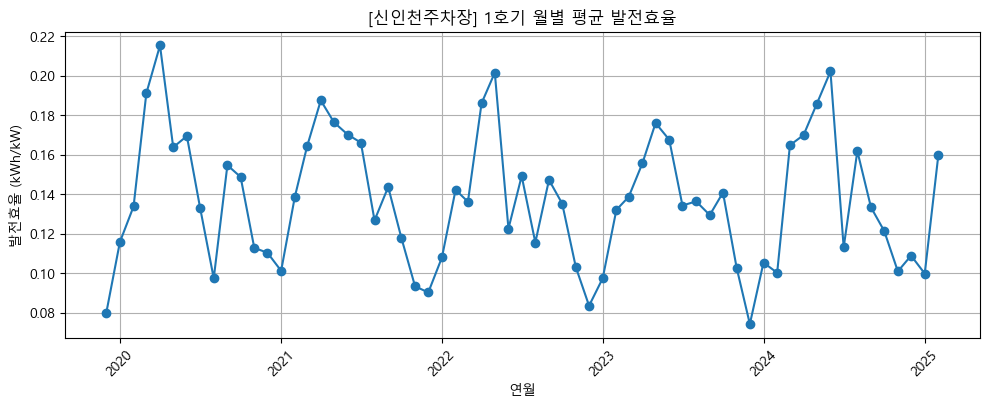

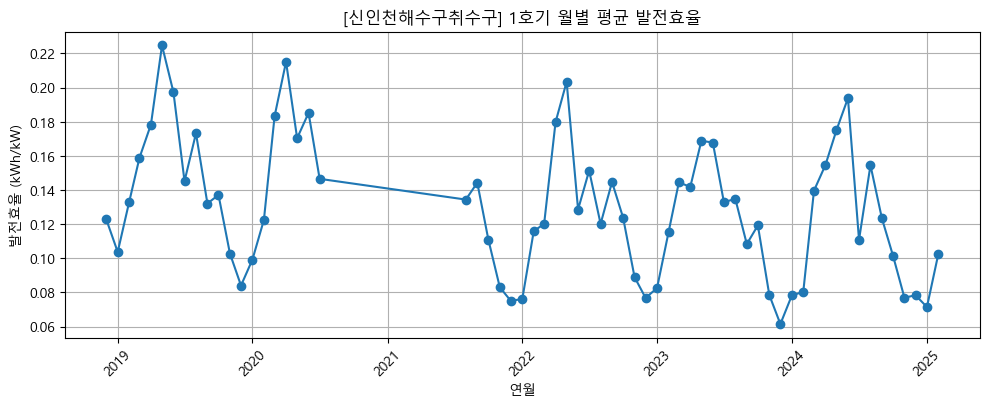

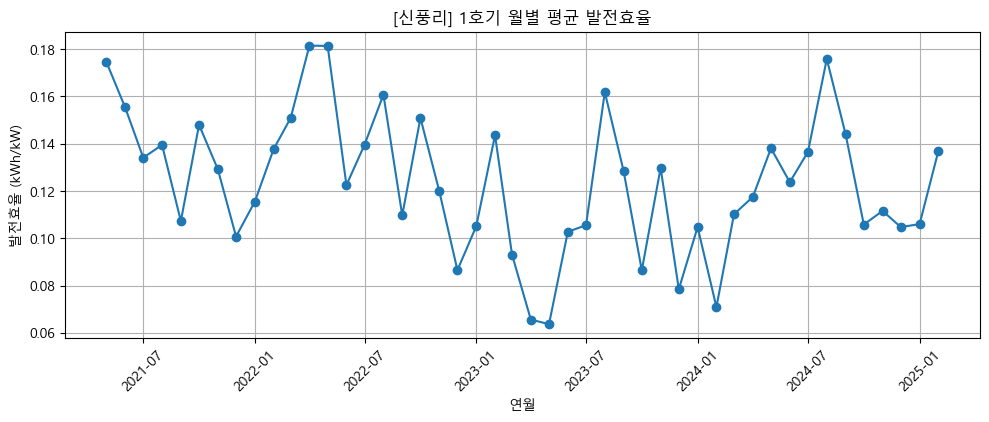

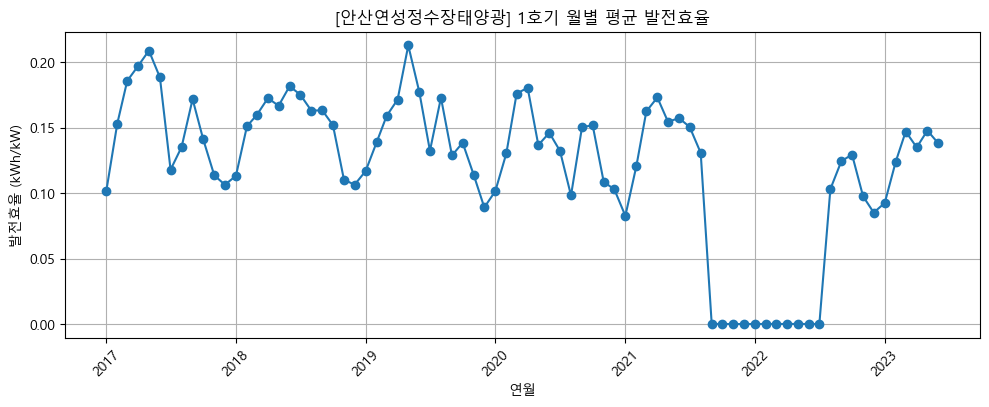

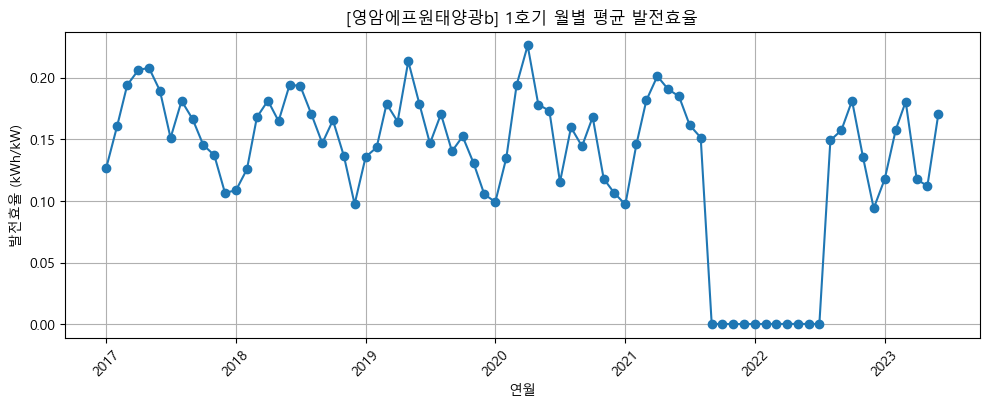

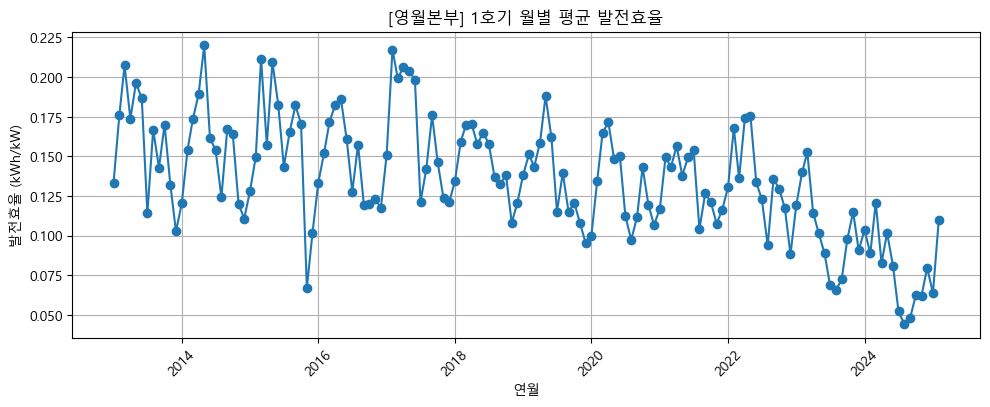

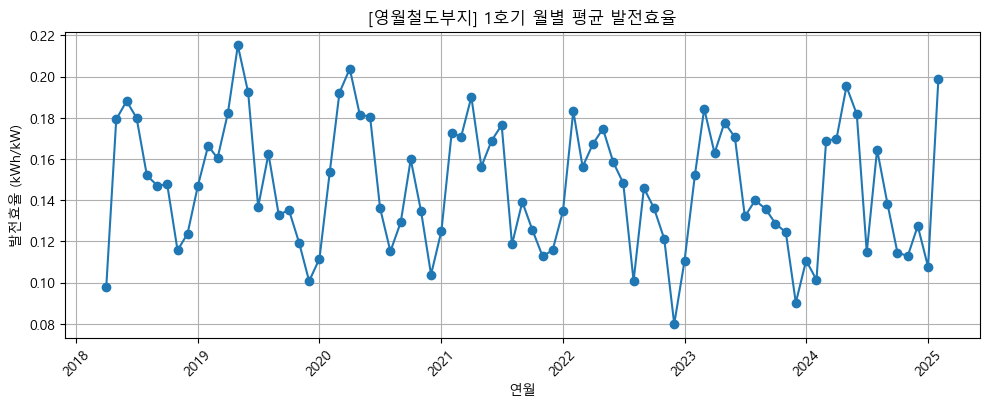

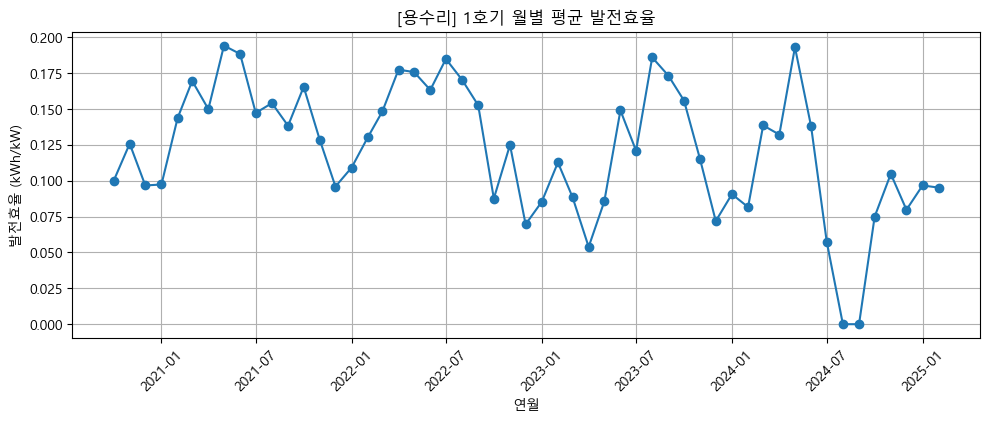

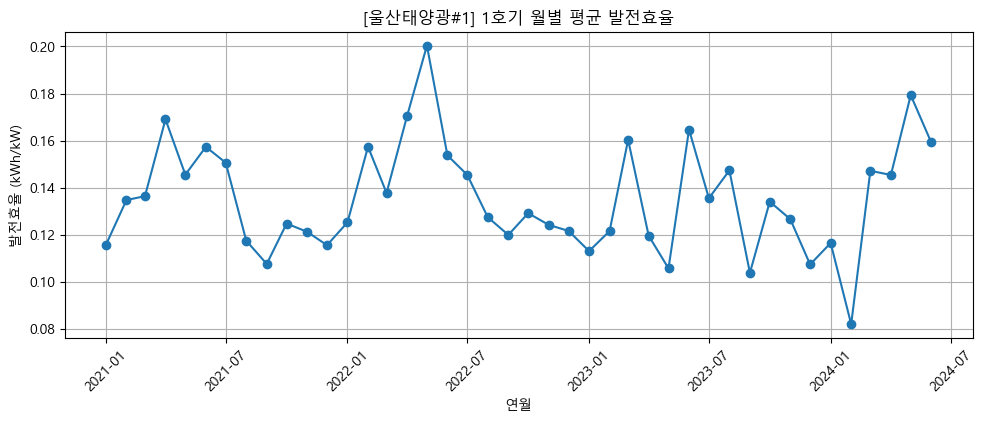

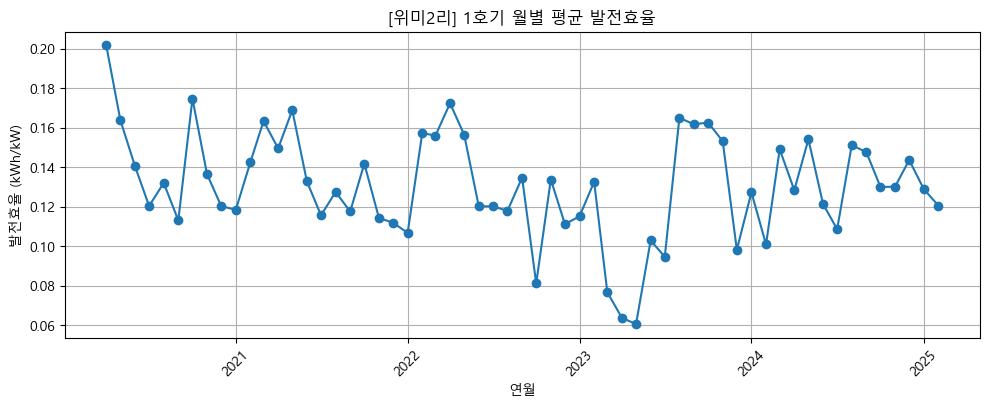

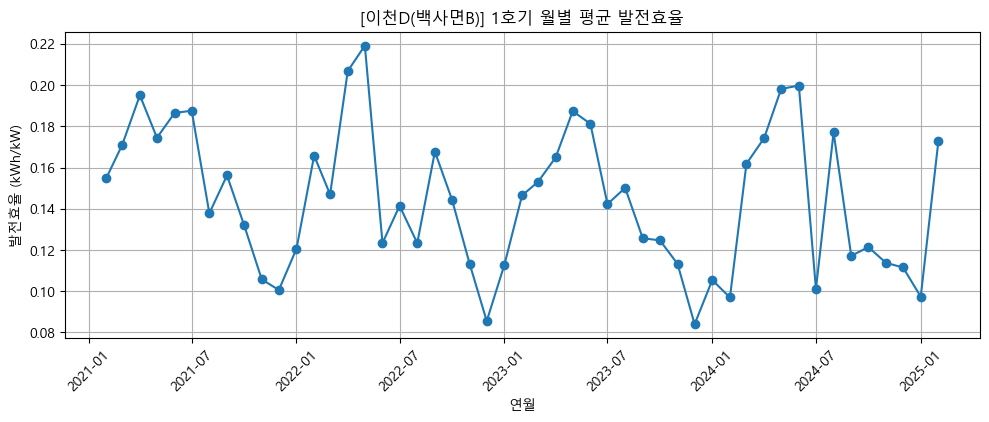

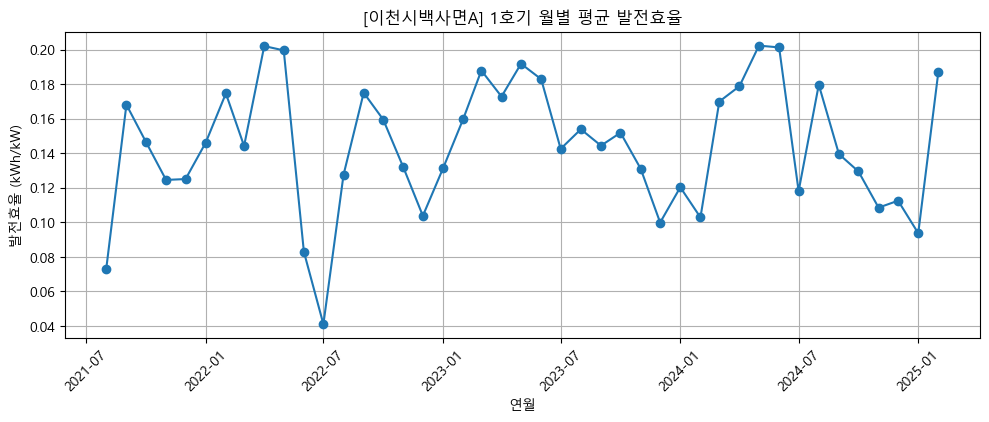

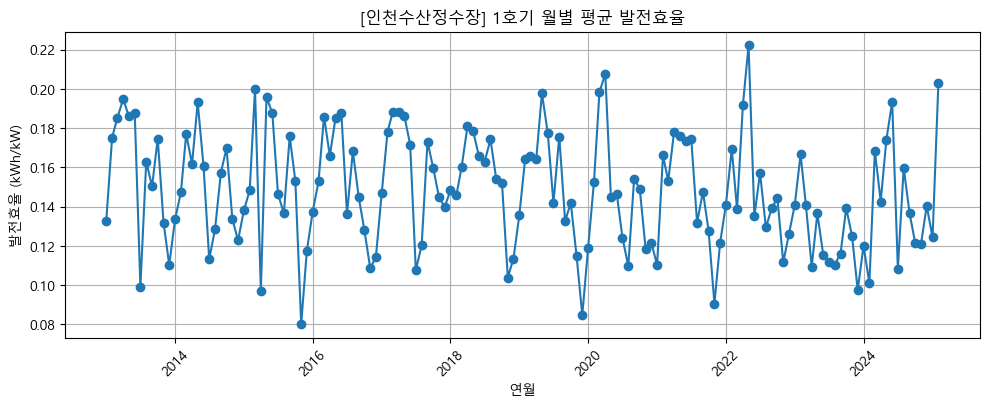

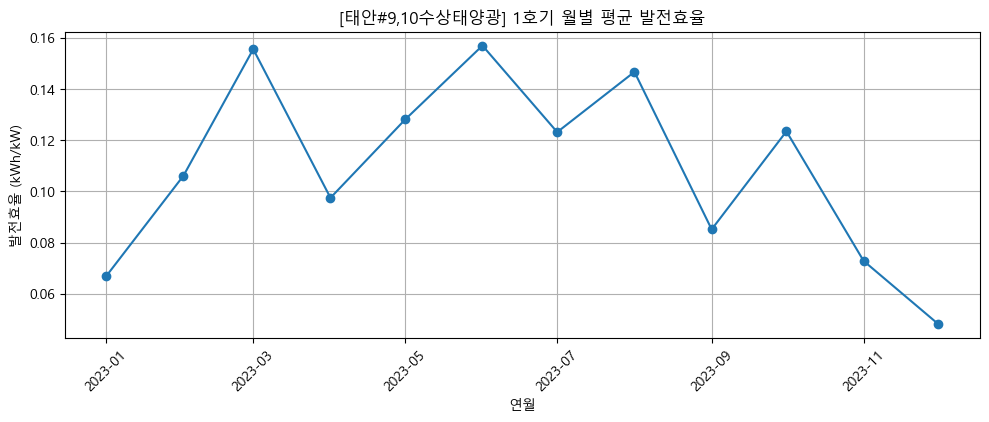

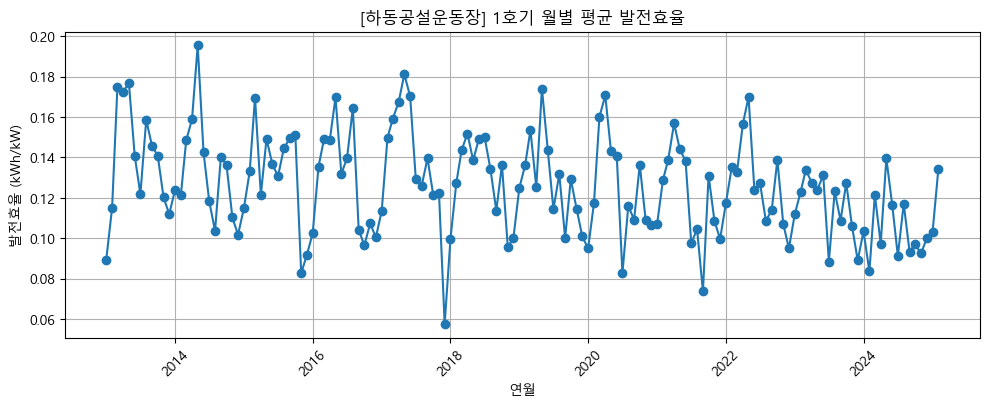

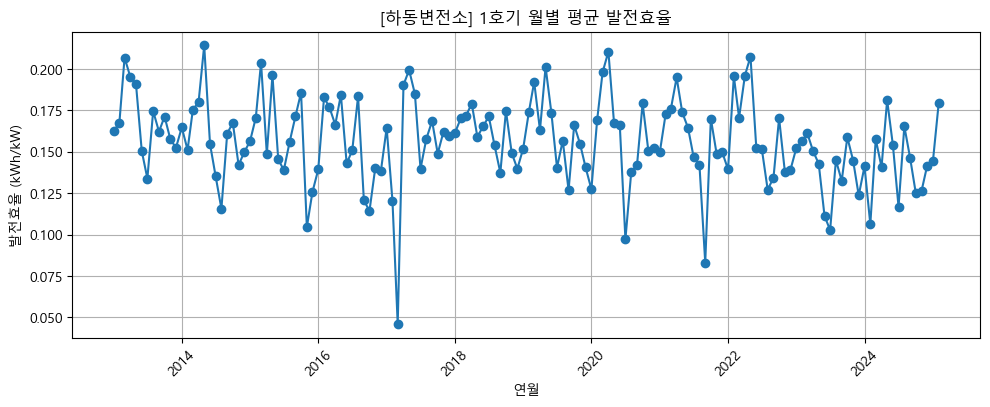

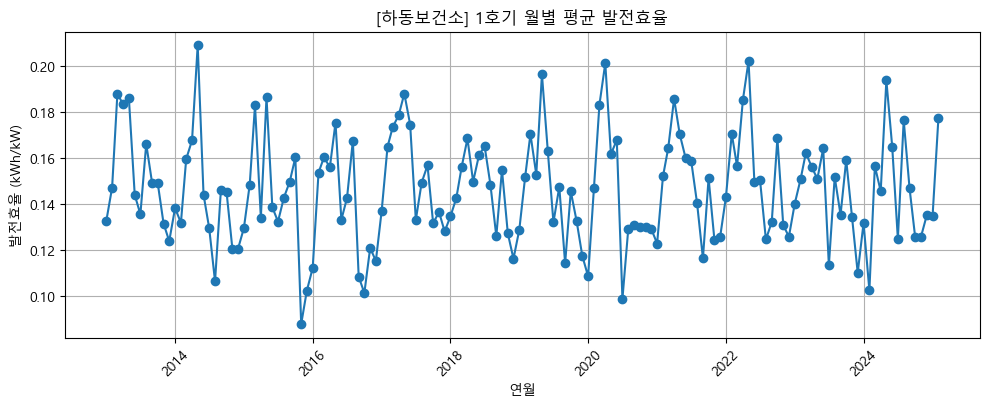

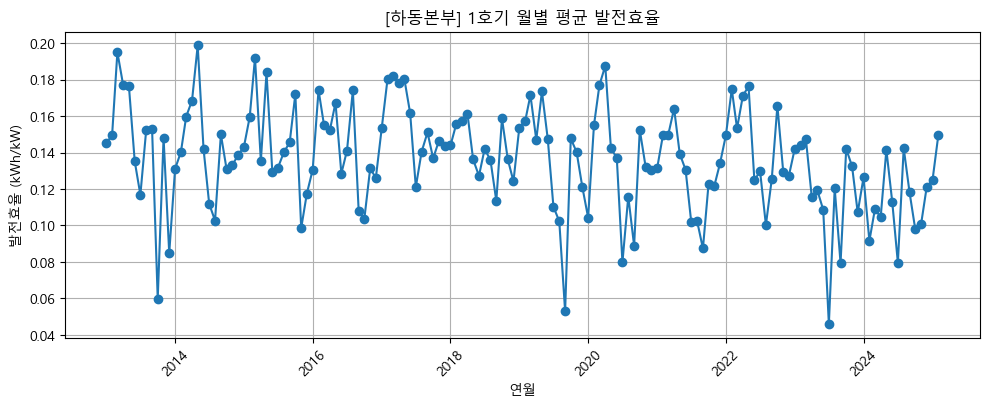

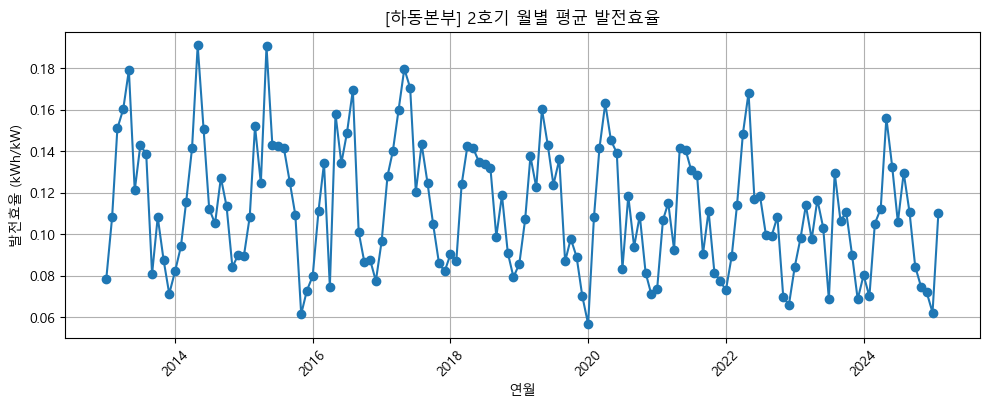

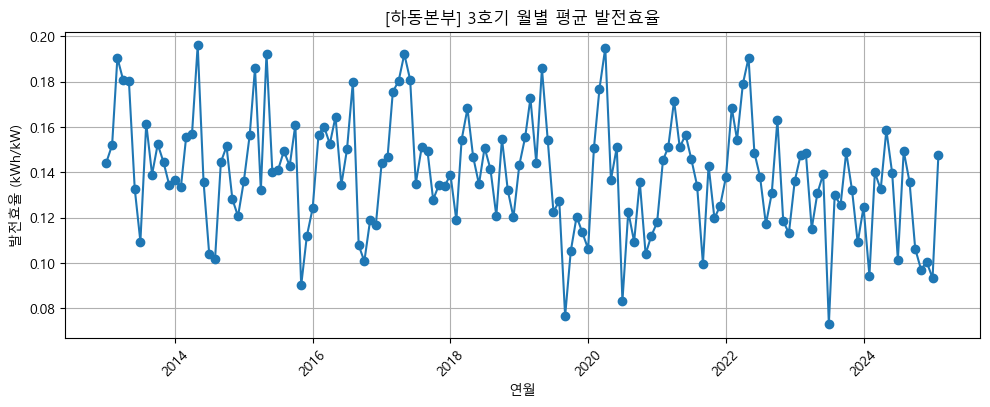

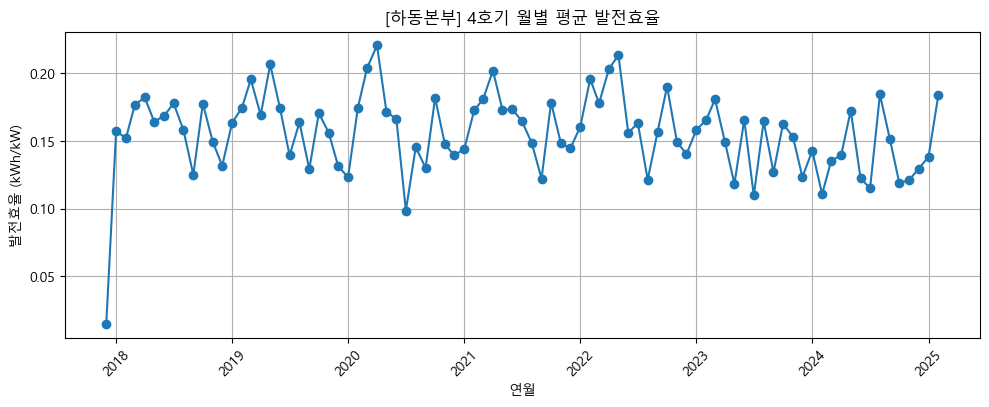

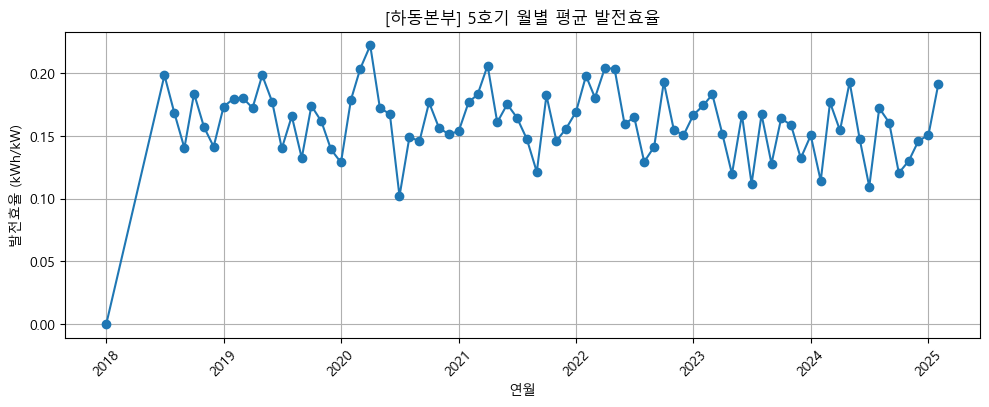

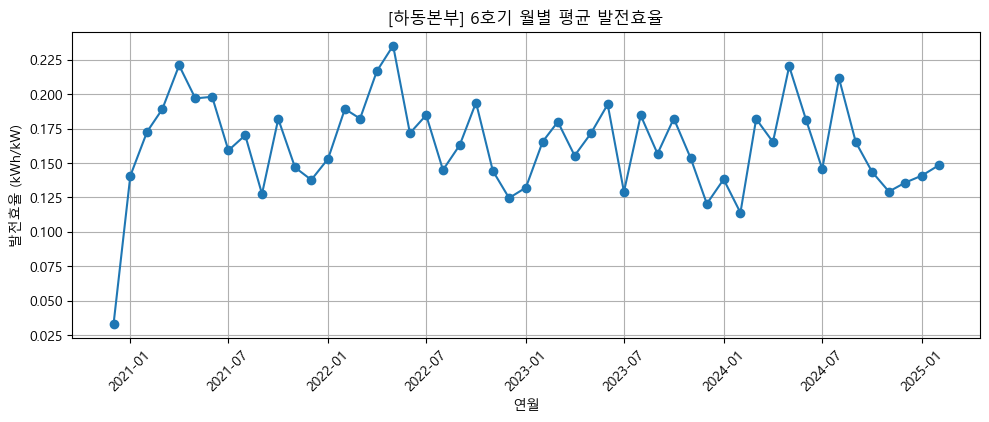

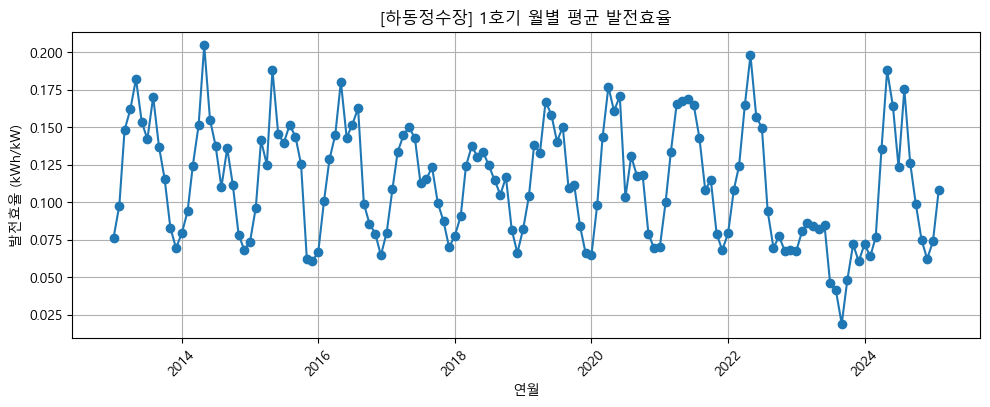

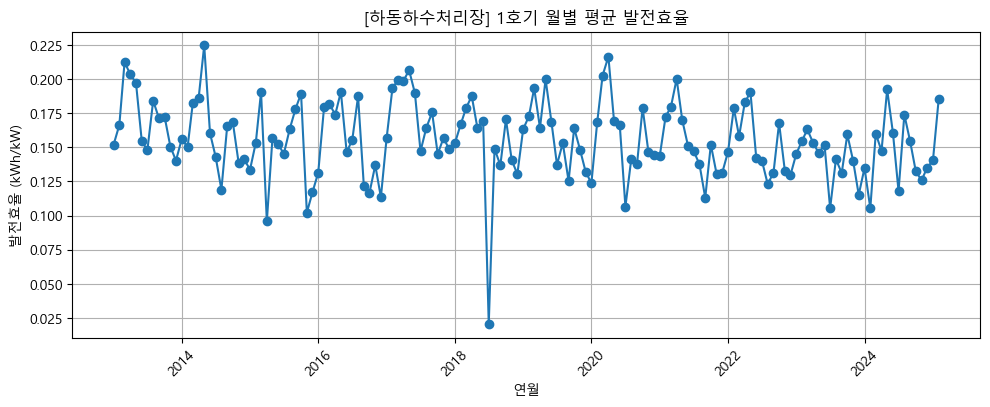

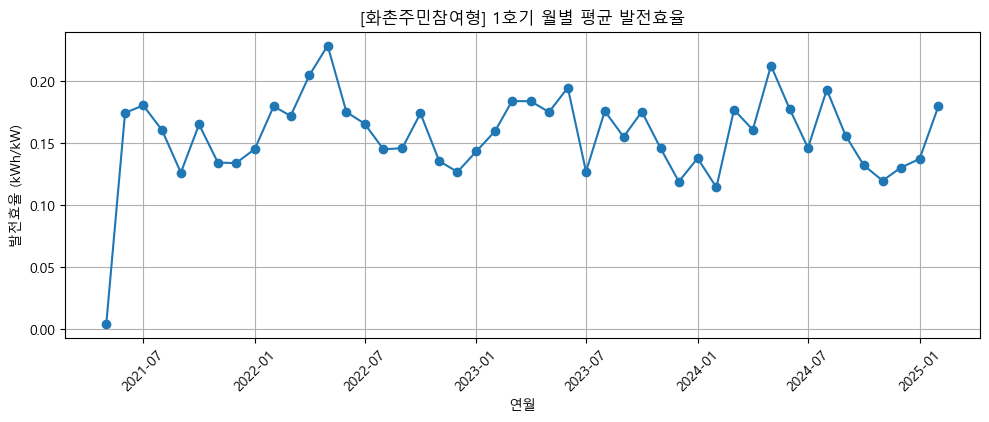

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm

# ✅ 한글 글꼴 설정 (운영체제별)
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 0. 설비용량과 발전량을 숫자로 변환 (콤마 제거 포함)
result_df['설비용량(MW)'] = (
    result_df['설비용량(MW)']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)
result_df['발전량'] = (
    result_df['발전량']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# 1. 발전효율 계산 (단위: kWh / MW → 발전시간당 효율)
result_df['발전효율'] = result_df['발전량'] / (result_df['설비용량(MW)'] * 1000)  # kWh / kW

# 2. 연월 컬럼 생성
result_df['연월'] = pd.to_datetime(result_df[['year', 'month']].astype(int).assign(day=1))

# 3. 월별 평균 발전효율
monthly_eff = (
    result_df.groupby(['발전구분', '호기', '연월'])['발전효율']
    .mean()
    .reset_index()
)

# 4. 발전구분-호기별 그래프 출력
unique_units = monthly_eff[['발전구분', '호기']].drop_duplicates()

for _, row in unique_units.iterrows():
    plant = row['발전구분']
    unit = row['호기']
    
    df_plot = monthly_eff[
        (monthly_eff['발전구분'] == plant) & (monthly_eff['호기'] == unit)
    ]

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['연월'], df_plot['발전효율'], marker='o')
    plt.title(f"[{plant}] {unit}호기 월별 평균 발전효율")
    plt.xlabel("연월")
    plt.ylabel("발전효율 (kWh/kW)")
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


In [8]:
# ✅ year, month, day를 정수형으로 변환
result_df['year'] = result_df['year'].astype(int)
result_df['month'] = result_df['month'].astype(int)
result_df['day'] = result_df['day'].astype(int)

# ✅ 필요한 컬럼만 순서대로 추출
cols_to_keep = ['발전구분', '호기', '설비용량(MW)', 'year', 'month', 'day', 'hour', '발전량', '발전효율']
result_df = result_df[cols_to_keep]

# ✅ 정렬
result_df = result_df.sort_values(by=['발전구분', '호기', 'year', 'month', 'day', 'hour']).reset_index(drop=True)

# ✅ 확인
print(result_df.dtypes)
print(result_df.head())



발전구분         object
호기           object
설비용량(MW)    float64
year          int32
month         int32
day           int32
hour          int32
발전량         float64
발전효율        float64
dtype: object
         발전구분 호기  설비용량(MW)  year  month  day  hour  발전량  발전효율
0  (군산)삼랑진태양광  1       2.0  2023      1    1     1  0.0   0.0
1  (군산)삼랑진태양광  1       2.0  2023      1    1     1  0.0   0.0
2  (군산)삼랑진태양광  1       2.0  2023      1    1     2  0.0   0.0
3  (군산)삼랑진태양광  1       2.0  2023      1    1     2  0.0   0.0
4  (군산)삼랑진태양광  1       2.0  2023      1    1     3  0.0   0.0


In [9]:
result_df.to_csv('../전처리_과정_데이터/병합완료.csv', index=False, encoding='utf-8-sig')